# AUC and performande using Selected Peptides

In [3]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from os.path import join, dirname, abspath
import shap
import tqdm

/opt/homebrew/Caskroom/miniconda/base/envs/SaaLab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
important_peptides = pd.read_csv(join('..', 'Results', 'Top100_SHAP_peptides_only.csv'))

In [6]:
important_peptides

,peptide_name,0
0,twist_54214,0.574447
1,twist_43798,0.306844
2,agilent_9025,0.208874
3,agilent_241665,0.203662
4,twist_51296,0.198013
...,...,...
95,agilent_169922,0.000772
96,corona2_425,0.000000
97,corona2_3290,0.000000
98,corona2_4309,0.000000


In [7]:
metadata = pd.read_csv(join('..', 'Data', 'metadata.csv')).dropna()
metadata['sample_id'] = metadata['sample_id'].apply(lambda x: str(x).replace('.', '-'))
metadata
metadata.set_index('sample_id', inplace = True)
exist_data = pd.read_csv(join('..', 'Data', 'exist.csv'))
exist_data = exist_data.T 
exist_data.columns = exist_data.iloc[0]
exist_data = exist_data[1:]

X = exist_data.copy().astype('category')

y = metadata['type_person']
y = y.apply(lambda x: 0 if x == 'Control' else 1).astype('category')

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut, KFold
from sklearn.model_selection import StratifiedKFold
n_features = len(important_peptides)
dict_cross_val = {
    'mean_accuracy': [],
    'std_accuracy': [],
    'mean_roc_auc': [],
    'std_roc_auc': [],
}
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'seed': 100,
    'alpha': 0.2
}


for i in tqdm.tqdm(range(n_features)):
    names = important_peptides[:i+1]['peptide_name'].to_list()
    X_subset = X[names]
    cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
    bst = XGBClassifier(**params, n_estimators=100, enable_categorical=True)
    scores = cross_val_score(bst, X_subset, y, cv=cv, scoring='accuracy', n_jobs=-1)
    dict_cross_val['mean_accuracy'].append(scores.mean())
    dict_cross_val['std_accuracy'].append(scores.std())
    scores_2 = cross_val_score(bst, X_subset, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    dict_cross_val['mean_roc_auc'].append(scores_2.mean())
    dict_cross_val['std_roc_auc'].append(scores_2.std())

100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Text(0, 0.5, 'Mean RUC AUC')

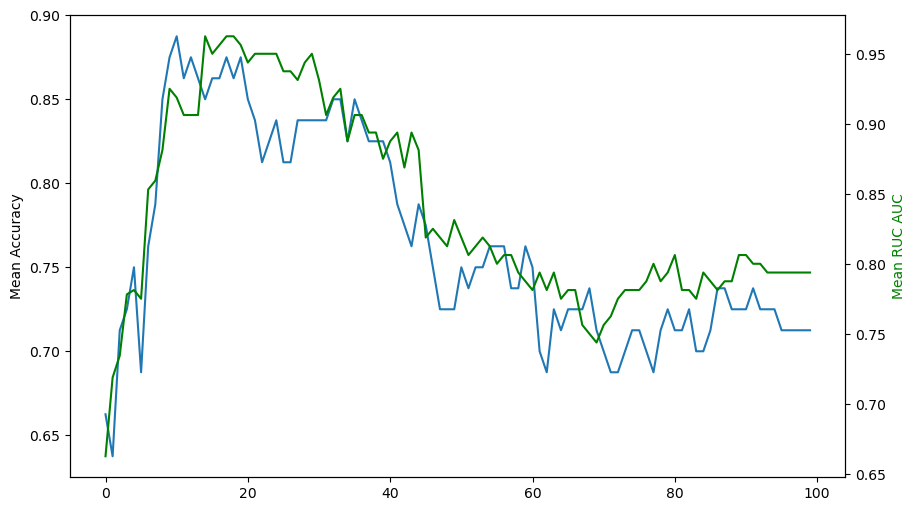

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dict_cross_val['mean_accuracy'])
ax.set_ylabel('Mean Accuracy')
axt = ax.twinx()
axt.plot(dict_cross_val['mean_roc_auc'], color = 'green')
axt.set_ylabel('Mean RUC AUC', color = 'green')

In [15]:
dict_cross_val['n_features'] = list(range(1, n_features + 1))
cross_val_df = pd.DataFrame(dict_cross_val)
# features = median_importance.index[:50].to_list()
cross_val_df.sort_values(by='mean_roc_auc', ascending=False, inplace=True)
n_features_optimal = cross_val_df.iloc[0]['n_features']
print(f'Optimal number of features: {n_features_optimal}'   )

Optimal number of features: 18.0
